## 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 데이터준비

In [4]:
CSV_PATH = 'daily_sales.csv'

df = pd.read_csv(CSV_PATH, parse_dates=['date'])
df['revenue'] = df['sales'] * df['price']
df['roll_mean_5'] = df['revenue'].rolling(5).mean()
df['roll_mean_20'] = df['revenue'].rolling(20).mean()
df.tail()

,date,sales,price,promo,revenue,roll_mean_5,roll_mean_20
725,2023-12-27,81.77,9.95,0,813.6115,707.41368,707.258050
726,2023-12-28,74.44,9.70,0,722.0680,716.93978,704.421910
727,2023-12-29,66.65,9.44,1,629.1760,716.27328,702.868090
728,2023-12-30,72.82,9.22,0,671.4004,722.54312,704.517635
729,2023-12-31,67.41,9.41,0,634.3281,694.11680,699.684440


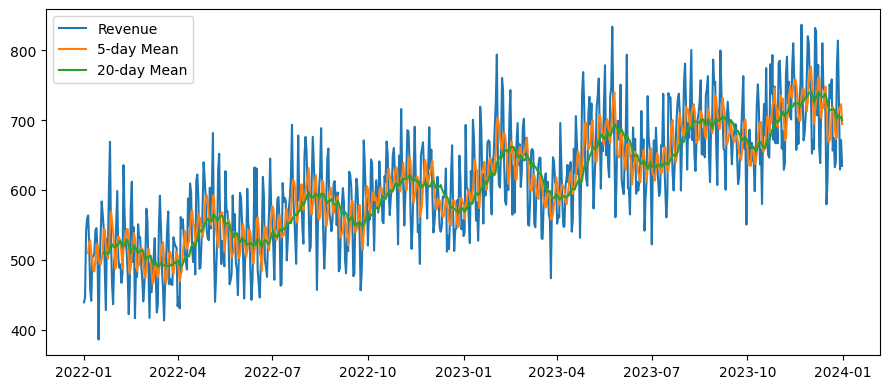

In [5]:
# 추세 시각화
plt.figure(figsize=(9,4))
plt.plot(df['date'], df['revenue'], label='Revenue')
plt.plot(df['date'], df['roll_mean_5'], label='5-day Mean')
plt.plot(df['date'], df['roll_mean_20'], label='20-day Mean')
plt.legend()
plt.tight_layout()
plt.show()

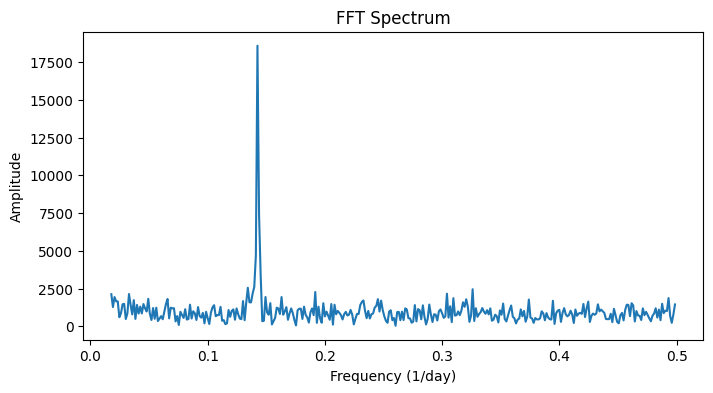

Dominant Frequency = 0.1425 (1/day)
Dominant Period = 7.02 days


In [6]:
# 계절성 확인을 위한 주기 시각화
from scipy.fft import fft, fftfreq

# 1) 데이터 준비
y = df['revenue'] - df['revenue'].mean()   # 평균 제거 (DC 성분 제거)
N = len(y)                             # 데이터 개수
d = 1                                  # 샘플 간격 (1일 단위 데이터면 1)

# 2) FFT 수행
yf = np.abs(fft(y))
xf = fftfreq(N, d=d)

# 3) 양의 주파수만 선택
pos_mask = xf > 0
xf = xf[pos_mask]
yf = yf[pos_mask]

# 4) 저주파(장기 추세) 제거
#  예: 60일보다 긴 주기(즉, 1/60 이하 주파수)는 무시
fmin = 1/60    # cutoff frequency
mask = xf >= fmin
xf = xf[mask]
yf = yf[mask]

# 5) 스펙트럼 시각화
plt.figure(figsize=(8,4))
plt.plot(xf, yf)
plt.title('FFT Spectrum')
plt.xlabel('Frequency (1/day)')
plt.ylabel('Amplitude')
plt.show()

# 6) 가장 강한 주파수 찾기
dominant_idx = np.argmax(yf)
dominant_freq = xf[dominant_idx]
dominant_period = 1 / dominant_freq

print(f"Dominant Frequency = {dominant_freq:.4f} (1/day)")
print(f"Dominant Period = {dominant_period:.2f} days")

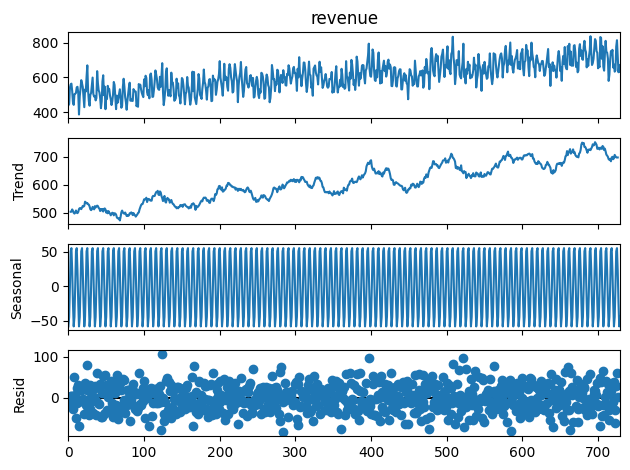

In [7]:
# 종합적으로 시각화
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['revenue'], model='additive', period=7)
result.plot()
plt.show()

추세 : 점차 상향하는 추세를 보임

계절성 : 7일 주기의 계절성을 보임

In [8]:
# 타겟 컬럼 생성
df['target_next'] = df['revenue'].shift(-1)
df = df.dropna().reset_index(drop=True)
df

,date,sales,price,promo,revenue,roll_mean_5,roll_mean_20,target_next
0,2022-01-20,52.08,10.44,0,543.7152,543.78590,509.400705,487.4030
1,2022-01-21,48.02,10.15,1,487.4030,542.85958,511.813455,428.0536
2,2022-01-22,41.08,10.42,0,428.0536,521.57720,510.908735,529.8594
3,2022-01-23,48.79,10.86,1,529.8594,510.83924,510.380855,518.0048
4,2022-01-24,49.24,10.52,0,518.0048,501.40720,508.329815,602.2146
...,...,...,...,...,...,...,...,...
705,2023-12-26,80.13,9.69,1,776.4597,675.95218,701.911665,813.6115
706,2023-12-27,81.77,9.95,0,813.6115,707.41368,707.258050,722.0680
707,2023-12-28,74.44,9.70,0,722.0680,716.93978,704.421910,629.1760
708,2023-12-29,66.65,9.44,1,629.1760,716.27328,702.868090,671.4004


In [9]:
feature_cols = [ c for c in df.columns if c not in ['date','sales','price','target_next']]
cut = int(len(df) * 0.8) # train/test 셋을 나누는 기준선

train, valid = df.iloc[:cut].copy(), df.iloc[cut:].copy()

X_tr, y_tr = train[feature_cols], train['target_next']
X_va, y_va = valid[feature_cols], valid['target_next']
(len(X_tr), len(X_va))

(568, 142)

## 학습 및 성능 비교

In [10]:
# Symmetric Mean Absolute Percentage Error, 대칭 평균 절대 백분율 오차
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1e-9, denom) # 0이면 나누기 연산 시 오류 날 수 있으므로 1e-9로 조정
    return 100 * np.mean(np.abs(y_true - y_pred) / denom)

def metric(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape_ = smape(y_true, y_pred)

    print(f'{name} : MAE = {mae:.4f}, RMSE = {rmse:.4f}, sMAPE = {smape_:.4f}%')
    return mae, rmse, smape_

In [11]:
yhat_naive = valid['revenue'].values # 오늘 데이터와 내일 데이터가 같을 것이라고 예측
m, r, s = metric(y_va, yhat_naive, "Naive")
# MAE = 4.5430, RMSE = 5.7322, sMAPE = 3.2562%

Naive : MAE = 50.9460, RMSE = 62.9922, sMAPE = 3.6441%


RandomForest : MAE = 51.7091, RMSE = 65.9190, sMAPE = 3.7230%


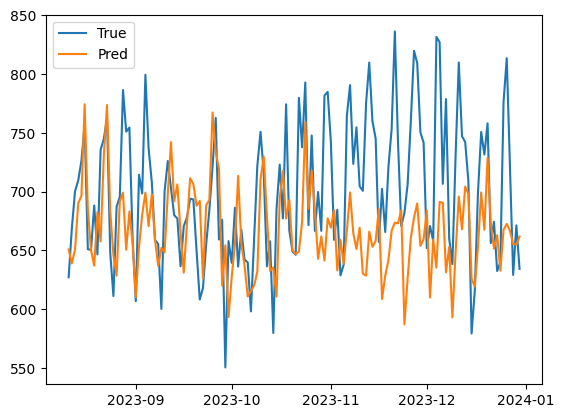

In [12]:
rf = RandomForestRegressor(n_estimators=400,
                           bootstrap=False,
                           max_features='sqrt',
                           random_state=RANDOM_STATE,
                           n_jobs=-1)
# bootstrap=False:매 트리에서 랜덤하게 데이터를 뽑지 않고 전체 데이터를 활용해서 학습
rf.fit(X_tr, y_tr)
pred_va = rf.predict(X_va)

m, r, s = metric(y_va, pred_va, "RandomForest")

plt.figure()
plt.plot(valid['date'], y_va, label='True')
plt.plot(valid['date'], pred_va, label='Pred')
plt.legend()
plt.show()

In [13]:
# TimeSeriesSplit 이용한 교차검증 (랜덤포레스트)
def evaluate_window(df_in, feature_cols, y_col):
    X = df_in[feature_cols]
    y = df_in[y_col]

    tscv = TimeSeriesSplit(n_splits=5) # 5번 교차검증 수행
    fold_metrics = []

    for k, (tr, te) in enumerate(tscv.split(X)): # tr, te는 인덱스로 받음
        X_tr, y_tr = X.iloc[tr], y.iloc[tr]
        X_te, y_te = X.iloc[te], y.iloc[te]

        rf = RandomForestRegressor(n_estimators=400,
                                   bootstrap=False,
                                   max_features='sqrt',
                                   random_state=RANDOM_STATE,
                                   n_jobs=-1)
        rf.fit(X_tr, y_tr)
        pred = rf.predict(X_te)

        mae = mean_absolute_error(y_te, pred)
        rmse = np.sqrt(mean_squared_error(y_te, pred))
        smape_rf = smape(y_te, pred)

        fold_metrics.append({'fold':k+1, 'MAE':mae, 'RMSE':rmse, 'sMAPE':smape_rf})

    return pd.DataFrame(fold_metrics)


bt = evaluate_window(df, feature_cols, 'target_next')
print(bt)
print('MAE mean +- std :', bt['MAE'].mean())


   fold        MAE       RMSE     sMAPE
0     1  55.579400  67.819050  5.051848
1     2  50.574867  62.942904  4.355716
2     3  58.595763  75.389547  4.755581
3     4  59.068084  73.952193  4.462209
4     5  56.956151  69.783454  4.090890
MAE mean +- std : 56.15485330508475


In [14]:
# 이동평균으로 예측
k = 7 # 계절성의 주기가 7이므로 7로 설정
hist = pd.concat([train['revenue'], valid['revenue']]) # 결측치가 없도록 concat
hist_ma = hist.rolling(k).mean() # 이동평균
hist_roll_aligned = hist_ma.loc[valid.index]
print(valid.index[0], valid.index[-1])
m, r, s = metric(y_va, hist_roll_aligned, "Moving Average(rolling=7)")

568 709
Moving Average(rolling=7) : MAE = 45.5805, RMSE = 56.5691, sMAPE = 3.2513%


In [15]:
# SimpleExpSmoothing
ses_fit = SimpleExpSmoothing(train['revenue'], initialization_method='estimated').fit()
ses_pred = ses_fit.predict(start=valid.index[0], end=valid.index[-1])
ses_pred_aligned = ses_pred.shift(-1)
# ses_pred[valid.index[0]+1] == ses_pred_aligned[valid.index[0]])

mask = ~ses_pred_aligned.isna()
m, r, s = metric(y_va[mask], ses_pred_aligned[mask], "SimpleExpSmoothing")

SimpleExpSmoothing : MAE = 48.9448, RMSE = 58.8695, sMAPE = 3.4917%


In [16]:
# Holt(추세 반영)
holt_fit = Holt(train['revenue'], initialization_method='estimated').fit()
holt_pred = holt_fit.predict(start=valid.index[0], end=valid.index[-1])
holt_pred_aligned = holt_pred.shift(-1)

mask = ~holt_pred_aligned.isna()
m, r, s = metric(y_va[mask], holt_pred_aligned[mask], "Holt")

Holt : MAE = 52.6793, RMSE = 63.6204, sMAPE = 3.7502%


In [17]:
# Holt-Winters(레벨 + 추세 + 계절성 반영)
s = 7
hw_fit = ExponentialSmoothing(
    train['revenue'], trend='add', seasonal='add', seasonal_periods=s, initialization_method='estimated').fit()
hw_pred = hw_fit.forecast(steps=len(y_va))
hw_pred_aligned = hw_pred.shift(-1)

mask = ~hw_pred_aligned.isna()
m, r, s = metric(y_va[mask], hw_pred_aligned[mask], "Holt-Winters")

Holt-Winters : MAE = 143.6906, RMSE = 160.7611, sMAPE = 9.2126%
